# Basic Introduction to Pairs Trading on Quantopian

The following presentation is heavily adapted from Delaney Granizo-Mackenzie's "Researching a Pairs Trading Strategy" presentation (https://notebooks-prod.herokuapp.com/previews?key=5346083a839ff34e1400010a%2Ffabe9a1d-6c50-4dbd-a636-4218b57c206f%2Fpreview.html&vf=true). 

We have simplified it for the sake of our Senior Seminar presentation, but we *fully credit* all code and work to Delaney. This is simply meant to demonstrate Pairs Trading on the most basic level so the class may understand how it works before we dive into the mathematical components.


---



In [51]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

## Explaining the Concept: Generating Two Fake Securities
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

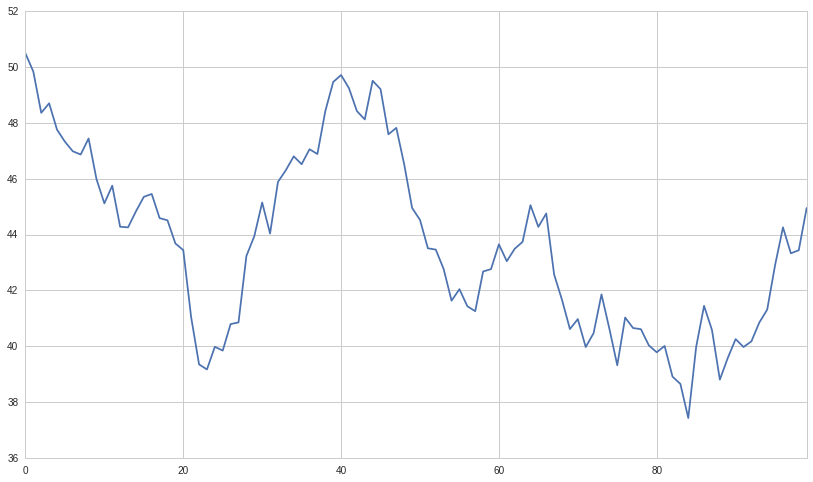

In [52]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot()

Generate Y by shifting X up and adding some random noise.

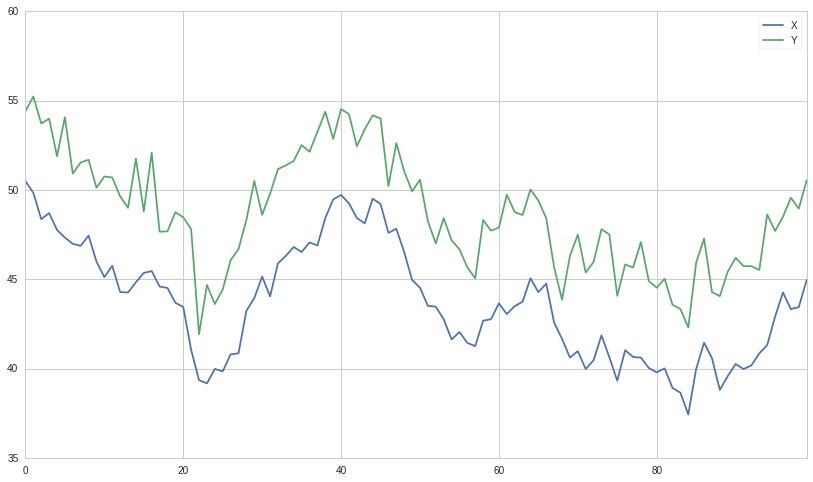

In [53]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot()

##Using X and Y to Demonstrate Cointegration

X and Y, in this case, is an example of a cointegrated series. The "spread" between the two timeseries will vary around a mean, and the expected value of the spread over time must converge to the mean in order for pairs trading to work.

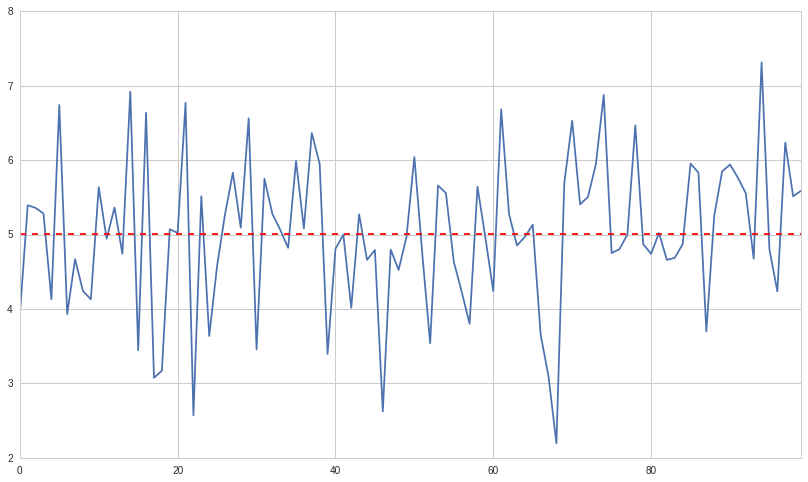

In [13]:
(Y-X).plot() # Plot the spread
plt.axhline((Y-X).mean(), color='red', linestyle='--') # Add the mean

##Testing for Cointegration

To test for cointegration, we compute the p-value. If it's very low, then co-integration exists!

In [14]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread btwn the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)
print pvalue

2.75767345363e-16


## Hedged Positions & Applications to Pairs Trading
In pairs trading, we maintain a "hedged position" to protect ourselves from market volatility. In this case, we "long" one stock and "short" the other. When X and Y are far apart, then we short Y and long X. When they're close together, we do the opposite.

## Moving onto real stocks
We now test for cointegration between actual stocks by performing a statistical test on stocks we think are co-integrated.

This method written by Delaney looks at a list of stocks and tests for cointegration between all of them.

In [15]:
def find_cointegrated_pairs(securities_panel):
    n = len(securities_panel.minor_axis)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities_panel.keys
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = securities_panel.minor_xs(securities_panel.minor_axis[i])
            S2 = securities_panel.minor_xs(securities_panel.minor_axis[j])
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((securities_panel.minor_axis[i], securities_panel.minor_axis[j]))
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Tech Stocks
Let's take a look at a bunch of different stocks in the tech industry and see if any of them are cointegrated, specifically looking at the daily closing price of the stock from 2017 to 2018.

In [24]:
symbol_list = ['TTWO', 'ATVI', 'EA', 'NVDA', 'FB', 'TWTR']
securities_panel = get_pricing(symbol_list, fields=['price']
                               , start_date='2017-01-01', end_date='2018-01-01')
securities_panel.minor_axis = map(lambda x: x.symbol, securities_panel.minor_axis)

Example of how to get all the prices of all the stocks loaded using get_pricing() above in one pandas dataframe object

In [25]:
securities_panel.loc['price'].head(5)

,TTWO,ATVI,EA,NVDA,FB,TWTR
2017-01-03 00:00:00+00:00,49.22,36.407,79.16,101.604,116.850,16.430
2017-01-04 00:00:00+00:00,50.14,37.133,80.63,103.995,118.691,16.860
2017-01-05 00:00:00+00:00,49.36,37.709,78.95,101.345,120.670,17.100
2017-01-06 00:00:00+00:00,49.95,37.659,79.01,102.730,123.430,17.175
2017-01-09 00:00:00+00:00,50.46,37.471,78.64,106.874,124.920,17.510


Now we'll run our method on the list and see if any pairs are cointegrated.

[(u'TTWO', u'FB')]


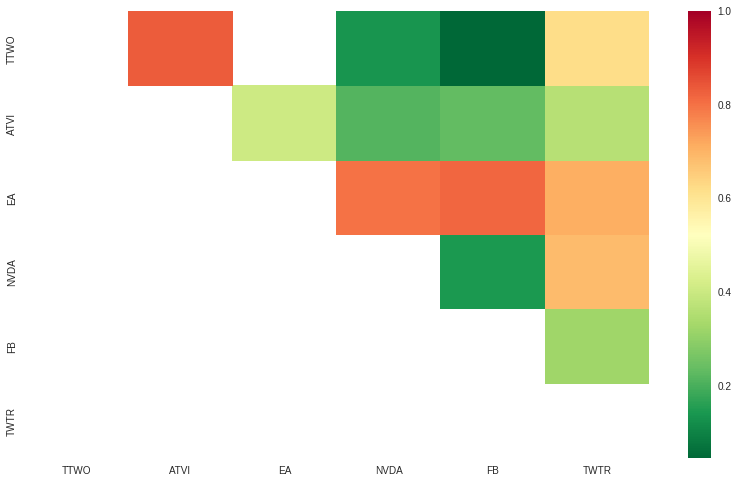

In [38]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
# (Just showing a '1' for everything in lower diagonal)

scores, pvalues, pairs = find_cointegrated_pairs(securities_panel)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )
print pairs

Looks like 'TTWO' and 'FB' are cointegrated. Just to double check....

In [35]:
S1 = securities_panel.loc['price']['TTWO']
S2 = securities_panel.loc['price']['FB']

In [36]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.046022074339030508

Now let's visualize the spread of the two stocks.

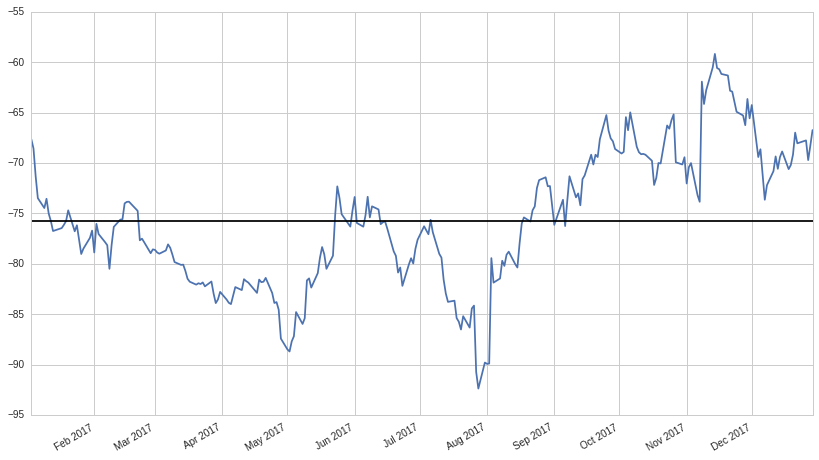

In [29]:
diff_series = S1 - S2
diff_series.plot()
plt.axhline(diff_series.mean(), color='black')

The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. This way we associate probabilities to the signals we see. If we see a z-score of 1, we know that approximately 84% of all spread values will be smaller.

In [37]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

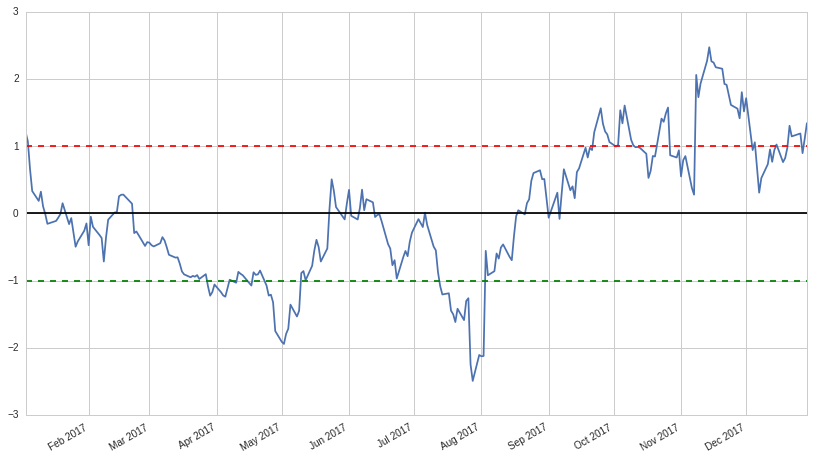

In [33]:
zscore(diff_series).plot()
plt.axhline(zscore(diff_series).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')


### Simple Strategy: 
* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero
* Since we originally defined the "spread" as S1-S2, "Long" the spread would mean "Buy 1 share of S1, and Sell Short 1 share of S2" (and vice versa if you were going "Short" the spread)

### Testing this: 
* https://www.quantopian.com/algorithms/5dca10fbd9af2e151761e3e4

### Some Comments:
This is the most basic way to conduct pairs trading. On a more high level, one may consider using more sophisticated statistics such as:
* Augmented-Dickey Fuller test 
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
* Kalman filters